In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
#spacy for lemmatization
import spacy

In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# NLTK for stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'ordinance', 'municipal', 'municipality', 'thereof'])

In [7]:
# Import Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [8]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [9]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# # Remove words ending with ING like amending, regulating
# data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]

pprint(data[:5])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR '
 'DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE RECONSTITUTING THE MEMBERS OF THE CITY TRICYCLE FRANCHISING '
 'AND REGULATORY BOARD (CTFRB) PRESCRIBING ITS FUNCTIONS AND PROCEDURES AND '
 'PROVIDING MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE UTILITY VEHICLE (TUV) '
 'AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, REGULATIONS AND OPERATIONS, '
 'THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE PROVISIONS AND PROVIDING '
 'PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT '
 'TAGUMENYOS, PROVIDING ITS MANAGEMENT, PROCEDURES AND GUIDELINES AND '
 'APPROPRIATING FUNDS THEREFOR”.',
 'AN ORDINANCE AMENDING THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY '
 'ORDINANCE NO. 820, S-2017 “AN ORDINANCE ENTERING INTO A LOAN AGREEMENT WITH '
 'THE DEVELOPMENT BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGH

In [10]:
#preprocess using gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['an', 'ordinance', 'regulating', 'the', 'practice', 'of', 'traditional', 'home', 'birth', 'delivery', 'or', 'deliveries', 'attended', 'by', 'traditional', 'birth', 'attendant', 'or', 'mananabang'], ['an', 'ordinance', 'reconstituting', 'the', 'members', 'of', 'the', 'city', 'tricycle', 'franchising', 'and', 'regulatory', 'board', 'ctfrb', 'prescribing', 'its', 'functions', 'and', 'procedures', 'and', 'providing', 'motorized', 'tricycle', 'for', 'hire', 'mth', 'tricycle', 'utility', 'vehicle', 'tuv', 'and', 'tricycle', 'utility', 'for', 'hire', 'tuh', 'guidelines', 'regulations', 'and', 'operations', 'the', 'collection', 'of', 'fees', 'charges', 'administrative', 'provisions', 'and', 'providing', 'penalties', 'for', 'violation', 'thereof'], ['an', 'ordinance', 'establishing', 'funeral', 'and', 'burial', 'assistance', 'for', 'indigent', 'tagumenyos', 'providing', 'its', 'management', 'procedures', 'and', 'guidelines', 'and', 'appropriating', 'funds', 'therefor'], ['an', 'ordinance', 'a

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['an', 'ordinance', 'regulating', 'the', 'practice', 'of', 'traditional', 'home', 'birth', 'delivery', 'or', 'deliveries', 'attended', 'by', 'traditional', 'birth', 'attendant', 'or', 'mananabang']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
#code snippets from Selva Prabhakaran | Topic Modeling with Gensim (Python)
by Selva Prabhakaran |
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:4])

[['regulate',
  'practice',
  'traditional',
  'home',
  'birth',
  'delivery',
  'delivery',
  'attend',
  'traditional',
  'birth',
  'attendant',
  'mananabang'],
 ['reconstitute',
  'member',
  'tricycle',
  'ctfrb',
  'prescribing',
  'function',
  'procedure',
  'provide',
  'tricycle',
  'utility',
  'vehicle',
  'tricycle',
  'utility',
  'hire',
  'guideline',
  'operation',
  'collection',
  'fee',
  'charge',
  'administrative',
  'provision',
  'provide',
  'penalty',
  'violation'],
 ['establish',
  'funeral',
  'burial_assistance',
  'indigent',
  'tagumenyos',
  'provide',
  'management',
  'procedure',
  'guideline',
  'appropriate',
  'fund'],
 ['amend',
  'title',
  'section',
  'section',
  'section',
  'enter',
  'loan',
  'amount',
  'acquisition',
  'equipment',
  'acquisition',
  'service',
  'vehicle',
  'acquisition',
  'continue_reading']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2)]]


In [15]:
id2word[0]

'attend'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attend', 1),
  ('attendant', 1),
  ('birth', 2),
  ('delivery', 2),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('regulate', 1),
  ('traditional', 2)]]

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.044*"impose" + 0.028*"area" + 0.022*"mayor" + 0.020*"fee" + 0.019*"require" + 0.017*"declare" + 0.015*"year" + 0.013*"reclassify" + 0.012*"lot" + 0.012*"rate"'), (1, '0.044*"provide" + 0.042*"fund" + 0.041*"create" + 0.028*"purpose" + 0.027*"position" + 0.025*"office" + 0.023*"authorize" + 0.022*"duty" + 0.021*"amount" + 0.016*"appropriate"'), (2, '0.038*"vehicle" + 0.031*"fee" + 0.023*"utility" + 0.022*"provide" + 0.019*"violation" + 0.019*"penalty" + 0.017*"street" + 0.017*"parking" + 0.015*"charge" + 0.014*"service"'), (3, '0.055*"penalty" + 0.049*"provide" + 0.048*"violation" + 0.041*"public" + 0.033*"regulate" + 0.018*"market" + 0.018*"prohibit" + 0.016*"use" + 0.014*"operation" + 0.014*"road"'), (4, '0.085*"amend" + 0.067*"section" + 0.025*"regulation" + 0.022*"provide" + 0.022*"tax" + 0.021*"establish" + 0.016*"traffic" + 0.015*"revise" + 0.014*"adopt" + 0.012*"school"')]


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.58157509186186

Coherence Score:  0.39513264860264863


In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.006496 -0.255043       1        1  25.770629
1     -0.193137  0.056686       2        1  25.416130
4     -0.137490  0.128210       3        1  18.727423
0      0.249652  0.142762       4        1  18.628086
2      0.074478 -0.072615       5        1  11.457732, topic_info=         Term        Freq       Total Category  logprob  loglift
38      amend  123.000000  123.000000  Default  30.0000  30.0000
44    section   84.000000   84.000000  Default  29.0000  29.0000
19    penalty  109.000000  109.000000  Default  28.0000  28.0000
28  violation   97.000000   97.000000  Default  27.0000  27.0000
47     create   70.000000   70.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
65    portion    7.911500   17.528682   Topic5  -4.5718   1.3710
28  violation   14.568384   97.720323   Topic5  -3.9612   0.2632
19    penalty   14.245852  109.082831   Topic5  -3.9836   0.1309
22    provide   16.647042  203.108580   Topic5  -3.8278  -0.3350
41      enter    5.047364    7.990375   Topic5  -5.0212   1.7071

[233 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
9         5  0.834061  administrative
257       3  0.979735           adopt
577       4  0.901552    agricultural
38        2  0.137285           amend
38        3  0.856013           amend
...     ...       ...             ...
509       4  0.729800          vendor
28        1  0.849363       violation
28        5  0.153499       violation
79        4  0.956573            year
412       4  0.965142            zone

[233 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 1, 3])

In [21]:
mallet_path = '/Users/root1/Documents/lda/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('create', 0.21351351351351353),
   ('purpose', 0.14324324324324325),
   ('position', 0.12972972972972974),
   ('duty', 0.1),
   ('compensation', 0.04594594594594595),
   ('officer', 0.043243243243243246),
   ('composition', 0.03783783783783784),
   ('function', 0.03783783783783784),
   ('power', 0.024324324324324326),
   ('cooperative', 0.01891891891891892)]),
 (11,
  [('fund', 0.13468013468013468),
   ('purpose', 0.09090909090909091),
   ('local', 0.08417508417508418),
   ('legislative', 0.07744107744107744),
   ('staff', 0.04713804713804714),
   ('qualification', 0.04713804713804714),
   ('department', 0.037037037037037035),
   ('providing', 0.030303030303030304),
   ('additional', 0.030303030303030304),
   ('assistant', 0.026936026936026935)]),
 (10,
  [('office', 0.14420062695924765),
   ('amount', 0.11912225705329153),
   ('authorize', 0.11598746081504702),
   ('mayor', 0.07523510971786834),
   ('appropriation', 0.0438871473354232),
   ('material', 0.03134796238244514),
 

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

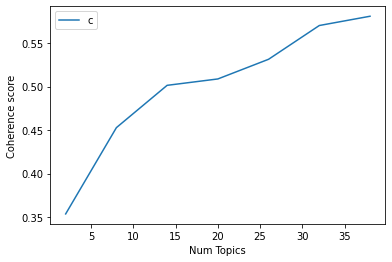

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3537
Num Topics = 8  has Coherence Value of 0.4529
Num Topics = 14  has Coherence Value of 0.5015
Num Topics = 20  has Coherence Value of 0.5088
Num Topics = 26  has Coherence Value of 0.5314
Num Topics = 32  has Coherence Value of 0.5702
Num Topics = 38  has Coherence Value of 0.5809


In [27]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(4,
  '0.135*"area" + 0.077*"portion" + 0.074*"reclassify" + 0.067*"lot" + '
  '0.067*"cover" + 0.051*"square_meter" + 0.051*"situate" + '
  '0.044*"continue_reading" + 0.030*"locate" + 0.027*"bound"'),
 (19,
  '0.339*"section" + 0.246*"amend" + 0.093*"tax" + 0.061*"article" + '
  '0.045*"chapter" + 0.038*"amending" + 0.029*"letter" + 0.022*"committee" + '
  '0.016*"payment" + 0.006*"provincial"'),
 (20,
  '0.327*"penalty" + 0.181*"violation" + 0.154*"provide" + 0.019*"gold" + '
  '0.015*"village" + 0.012*"issue" + 0.012*"open" + 0.012*"home" + '
  '0.012*"road" + 0.012*"sell"'),
 (0,
  '0.290*"purpose" + 0.129*"create" + 0.069*"composition" + 0.037*"power" + '
  '0.037*"salary" + 0.032*"office" + 0.032*"fund" + 0.028*"engage" + '
  '0.028*"set" + 0.023*"territorial_jurisdiction"'),
 (21,
  '0.199*"government" + 0.087*"provide" + 0.056*"property" + 0.048*"approve" + '
  '0.048*"real" + 0.035*"schedule" + 0.030*"council" + 0.030*"subject" + '
  '0.026*"national" + 0.022*"level"'),
 (17

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.0973,"service, barangay, operate, include, cable, is...",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,1,23.0,0.1987,"provide, function, operation, prescribing, fee...",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,2,3.0,0.0506,"guideline, policy, benefit, incentive, qualify...",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,3,19.0,0.0928,"section, amend, tax, article, chapter, amendin...","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,4,21.0,0.0541,"government, provide, property, approve, real, ...","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."
5,5,9.0,0.0562,"provide, fund, series, purpose, repeal, civil,...",“AN ORDINANCE INSTITUTIONALIZING THE HUGPONG S...
6,6,11.0,0.0541,"market, declare, vendor, site, part, stall, te...",“AN ORDINANCE DECLARING THE AREA IN FRONT OF T...
7,7,25.0,0.0701,"establish, implementation, program, educationa...",AN ORDINANCE AMENDING SECTION 2 OF CITY ORDINA...
8,8,8.0,0.0752,"service, barangay, operate, include, cable, is...",AN ORDINANCE GRANTING THE TEMPORARY CLOSURE OF...
9,9,1.0,0.1547,"penalty, violation, street, road, traffic, clo...",“AN ORDINANCE GRANTING TEMPORARY CLOSURE FROM ...


In [29]:
# Convert malletmodel to to gensim lda model for pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [30]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/root1/Documents/lda/myvenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.123562  0.175330       1        1  5.211959
6     -0.273801  0.089359       2        1  5.175226
5      0.082363 -0.272853       3        1  5.104668
2      0.065535  0.051532       4        1  5.072452
8     -0.064056 -0.036713       5        1  5.053539
18     0.100969  0.125485       6        1  5.036848
14     0.080506 -0.032406       7        1  5.036088
17     0.078907 -0.069274       8        1  5.009989
11     0.009707 -0.340977       9        1  4.990726
10     0.091160  0.061427      10        1  4.982152
19     0.051092 -0.006891      11        1  4.972617
1      0.055122  0.097030      12        1  4.965643
0      0.106604  0.056956      13        1  4.964879
4      0.082685 -0.032264      14        1  4.946574
12     0.089313  0.067520      15        1  4.939888
15     0.049729 -0.045689      16        1  4.938692
13    -0.295439 -0.101400      17        1  4.936028
7      0.108876  0.075451      18        1  4.894874
16    -0.260372  0.064113      19        1  4.890132
3     -0.282461  0.074262      20        1  4.877027, topic_info=          Term        Freq       Total Category  logprob  loglift
22     provide  258.000000  258.000000  Default  30.0000  30.0000
38       amend  118.000000  118.000000  Default  29.0000  29.0000
19     penalty  106.000000  106.000000  Default  28.0000  28.0000
44     section   88.000000   88.000000  Default  27.0000  27.0000
32        fund  117.000000  117.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
797     budget    2.238405    3.304661  Topic20  -4.9802   2.6311
1224     plate    1.119202    1.119202  Topic20  -5.6733   3.0206
487   employee    3.357607    9.034771  Topic20  -4.5747   2.0308
362      serve    2.238405    4.194438  Topic20  -4.9802   2.3926
70       order    2.238405    7.524726  Topic20  -4.9802   1.8082

[1065 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1246     10  0.958798    abbatoir
237      20  0.893494      access
591      11  1.041945    accident
1028     18  0.966717  accountant
704      20  0.893494  accounting
...     ...       ...         ...
108      17  0.399464      worker
79       15  0.990819        year
412       8  0.148836        zone
412      14  0.818596        zone
1321      6  0.897846   zonifying

[1163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 6, 3, 9, 19, 15, 18, 12, 11, 20, 2, 1, 5, 13, 16, 14, 8, 17, 4])